In [1]:
import pandas as pd
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import bigrams
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc
# from sklearnex import patch_sklearn
# from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from imblearn.over_sampling import RandomOverSampler, SMOTE
# patch_sklearn()
nltk.download('stopwords')
nltk.download('punkt')

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /Users/lhx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lhx/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
#preprocessing
movie_details = pd.read_json('Datasets/IMDB_movie_details.json', lines = True)
imdb_reviews = pd.read_json('Datasets/IMDB_reviews.json', lines = True)

In [3]:
#check for na
"""no_summary = movie_details[movie_details['plot_summary'].isna()]
no_summary"""

"no_summary = movie_details[movie_details['plot_summary'].isna()]\nno_summary"

In [4]:
#check for na
"""no_synopsis = movie_details[movie_details['plot_synopsis'].isna()]
no_synopsis"""

"no_synopsis = movie_details[movie_details['plot_synopsis'].isna()]\nno_synopsis"

In [5]:
#check for na
"""no_review = imdb_reviews[imdb_reviews['review_text'].isna()]
no_review"""

"no_review = imdb_reviews[imdb_reviews['review_text'].isna()]\nno_review"

In [6]:
#functions for preprocessing
def lowercase(dataframe,columnname):
    lowercase_dataframe = dataframe[columnname].apply(lambda x: x.lower() if isinstance(x,str) else x)
    return lowercase_dataframe

def remove_special_characters(dataframe,columnname):
    dataframe_no_special_characters = dataframe[columnname].replace(r'[^A-Za-z0-9 ]+', '', regex=True)
    return dataframe_no_special_characters

def tokenize_words(dataframe,columnname):
    dataframe_tokenized_texts= dataframe[columnname].apply(lambda x: word_tokenize(x) )
    return dataframe_tokenized_texts

def remove_stop_words(dataframe,columnname):
    stop = stopwords.words('english')
    dataframe_no_stop_words= dataframe[columnname].apply(lambda x: [item for item in x if item not in stop])
    return dataframe_no_stop_words

def lemmatize_text(dataframe,columnname):
    lemmatizer = WordNetLemmatizer()
    lemmatized = dataframe[columnname].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, pos = 'v') for word in x.split(' ')]))
    lemmatized = lemmatized.apply(lambda x: ' '.join([lemmatizer.lemmatize(word, pos = 'a') for word in x.split(' ')]))
    lemmatized = lemmatized.apply(lambda x: ' '.join([lemmatizer.lemmatize(word, pos = 's') for word in x.split(' ')]))
    lemmatized = lemmatized.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split(' ')]))
    #text = ' '.join([lemmatizer.lemmatize(word) if lemmatizer.lemmatize(word) is not None else word for word in text.split()])
    return lemmatized


In [7]:
# #Processing of data
# imdb_reviews = imdb_reviews.head()
# imdb_reviews['review_text'] = lowercase(imdb_reviews,'review_text')
# imdb_reviews['review_text'] = remove_special_characters(imdb_reviews,'review_text')
# imdb_reviews['review_text'] = tokenize_words(imdb_reviews,'review_text')
# imdb_reviews['review_text'] = remove_stop_words(imdb_reviews,'review_text')
# imdb_reviews

In [8]:
#change to lowercase
imdb_reviews['review_text'] = lowercase(imdb_reviews,'review_text')
#remove special characters
imdb_reviews['review_text'] = remove_special_characters(imdb_reviews,'review_text')
# imdb_reviews['review_text'] = lemmatize_text(imdb_reviews,'review_text')
#tokenize text 15min
imdb_reviews['review_text'] = tokenize_words(imdb_reviews,'review_text')
#remove stop words 8min
imdb_reviews['review_text'] = remove_stop_words(imdb_reviews,'review_text')
imdb_reviews['is_spoiler'] = imdb_reviews['is_spoiler'].map({True: 1, False: 0})
imdb_reviews.head()

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,1,"[oscar, year, shawshank, redemption, written, ...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,1,"[shawshank, redemption, without, doubt, one, b...",10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,1,"[believe, film, best, story, ever, told, film,...",8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,1,"[yes, spoilers, herethis, film, emotional, imp...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,1,"[heart, extraordinary, movie, brilliant, indel...",8,"Great story, wondrously told and acted"


after attempt to lemmatise the text before tokenizing and removing stop words, we realise that the accuracy for each model attempted increases slightly. however, the f1 score of each model decreases, it could be caused by the loss of information when converting all noun, verb and adjective to their root form and the impact on tokenization from doing so, since it may affects the sensitivity of the model and affect the results on the minority class, causing decreasing in f1 score despite increase in accuracy. (f1 score is more balanced evaluation of the model)
-> ability to detect spoiler decreases as it seems to identify more spoilers as non spoiler. 

In [9]:
#bigrams and bigram text
imdb_reviews['bigrams'] = imdb_reviews['review_text'].apply(lambda x: list(bigrams(x)))
imdb_reviews['bigram_text'] = imdb_reviews['bigrams'].apply(lambda x: ' '.join([' '.join(bigram) for bigram in x]))

In [10]:
imdb_reviews.to_csv('Datasets/imdb_reviews_nostop_bigrams.csv',index=True)

In [11]:
#From csv file with bigrams text
imdb_reviews_bigrams = pd.read_csv('Datasets/imdb_reviews_nostop_bigrams.csv')

In [12]:
imdb_reviews_bigrams.head()

,Unnamed: 0,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary,bigrams,bigram_text
0,0,10 February 2006,tt0111161,ur1898687,1,"['oscar', 'year', 'shawshank', 'redemption', '...",10,A classic piece of unforgettable film-making.,"[('oscar', 'year'), ('year', 'shawshank'), ('s...",oscar year year shawshank shawshank redemption...
1,1,6 September 2000,tt0111161,ur0842118,1,"['shawshank', 'redemption', 'without', 'doubt'...",10,Simply amazing. The best film of the 90's.,"[('shawshank', 'redemption'), ('redemption', '...",shawshank redemption redemption without withou...
2,2,3 August 2001,tt0111161,ur1285640,1,"['believe', 'film', 'best', 'story', 'ever', '...",8,The best story ever told on film,"[('believe', 'film'), ('film', 'best'), ('best...",believe film film best best story story ever e...
3,3,1 September 2002,tt0111161,ur1003471,1,"['yes', 'spoilers', 'herethis', 'film', 'emoti...",10,Busy dying or busy living?,"[('yes', 'spoilers'), ('spoilers', 'herethis')...",yes spoilers spoilers herethis herethis film f...
4,4,20 May 2004,tt0111161,ur0226855,1,"['heart', 'extraordinary', 'movie', 'brilliant...",8,"Great story, wondrously told and acted","[('heart', 'extraordinary'), ('extraordinary',...",heart extraordinary extraordinary movie movie ...


In [13]:
# #check for na
# imdb_reviews_bigrams[imdb_reviews_bigrams['bigram_text'].isna()]

In [14]:
# #remove na data
imdb_reviews_bigrams = imdb_reviews_bigrams.dropna(subset=['bigram_text'])
imdb_reviews_bigrams.head()

,Unnamed: 0,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary,bigrams,bigram_text
0,0,10 February 2006,tt0111161,ur1898687,1,"['oscar', 'year', 'shawshank', 'redemption', '...",10,A classic piece of unforgettable film-making.,"[('oscar', 'year'), ('year', 'shawshank'), ('s...",oscar year year shawshank shawshank redemption...
1,1,6 September 2000,tt0111161,ur0842118,1,"['shawshank', 'redemption', 'without', 'doubt'...",10,Simply amazing. The best film of the 90's.,"[('shawshank', 'redemption'), ('redemption', '...",shawshank redemption redemption without withou...
2,2,3 August 2001,tt0111161,ur1285640,1,"['believe', 'film', 'best', 'story', 'ever', '...",8,The best story ever told on film,"[('believe', 'film'), ('film', 'best'), ('best...",believe film film best best story story ever e...
3,3,1 September 2002,tt0111161,ur1003471,1,"['yes', 'spoilers', 'herethis', 'film', 'emoti...",10,Busy dying or busy living?,"[('yes', 'spoilers'), ('spoilers', 'herethis')...",yes spoilers spoilers herethis herethis film f...
4,4,20 May 2004,tt0111161,ur0226855,1,"['heart', 'extraordinary', 'movie', 'brilliant...",8,"Great story, wondrously told and acted","[('heart', 'extraordinary'), ('extraordinary',...",heart extraordinary extraordinary movie movie ...


In [15]:
#vectorize bigram text
vectorizer = CountVectorizer()
matrix = vectorizer.fit_transform(imdb_reviews_bigrams['review_text'])

In [16]:
imdb_reviews_bigrams

,Unnamed: 0,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary,bigrams,bigram_text
0,0,10 February 2006,tt0111161,ur1898687,1,"['oscar', 'year', 'shawshank', 'redemption', '...",10,A classic piece of unforgettable film-making.,"[('oscar', 'year'), ('year', 'shawshank'), ('s...",oscar year year shawshank shawshank redemption...
1,1,6 September 2000,tt0111161,ur0842118,1,"['shawshank', 'redemption', 'without', 'doubt'...",10,Simply amazing. The best film of the 90's.,"[('shawshank', 'redemption'), ('redemption', '...",shawshank redemption redemption without withou...
2,2,3 August 2001,tt0111161,ur1285640,1,"['believe', 'film', 'best', 'story', 'ever', '...",8,The best story ever told on film,"[('believe', 'film'), ('film', 'best'), ('best...",believe film film best best story story ever e...
3,3,1 September 2002,tt0111161,ur1003471,1,"['yes', 'spoilers', 'herethis', 'film', 'emoti...",10,Busy dying or busy living?,"[('yes', 'spoilers'), ('spoilers', 'herethis')...",yes spoilers spoilers herethis herethis film f...
4,4,20 May 2004,tt0111161,ur0226855,1,"['heart', 'extraordinary', 'movie', 'brilliant...",8,"Great story, wondrously told and acted","[('heart', 'extraordinary'), ('extraordinary',...",heart extraordinary extraordinary movie movie ...
...,...,...,...,...,...,...,...,...,...,...
573908,573908,8 August 1999,tt0139239,ur0100166,0,"['go', 'wise', 'fast', 'pure', 'entertainment'...",10,The best teen movie of the nineties,"[('go', 'wise'), ('wise', 'fast'), ('fast', 'p...",go wise wise fast fast pure pure entertainment...
573909,573909,31 July 1999,tt0139239,ur0021767,0,"['well', 'shall', 'say', 'ones', 'fun', 'rate'...",9,Go - see the movie,"[('well', 'shall'), ('shall', 'say'), ('say', ...",well shall shall say say ones ones fun fun rat...
573910,573910,20 July 1999,tt0139239,ur0392750,0,"['go', 'best', 'movie', 'ever', 'seen', 'ive',...",10,It's the best movie I've ever seen,"[('go', 'best'), ('best', 'movie'), ('movie', ...",go best best movie movie ever ever seen seen i...
573911,573911,11 June 1999,tt0139239,ur0349105,0,"['call', '1999', 'teenage', 'version', 'pulp',...",3,Haven't we seen this before?,"[('call', '1999'), ('1999', 'teenage'), ('teen...",call 1999 1999 teenage teenage version version...


In [17]:
# Split the data into training and testing sets
X = matrix
y = imdb_reviews_bigrams['is_spoiler']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SelectKBest with chi-squared as the score function
k_best_selector = SelectKBest(score_func=chi2, k=100) #can change k accordingly

X_train_selected = k_best_selector.fit_transform(X_train, y_train)
X_test_selected = k_best_selector.transform(X_test) 

Accuracy: 0.76
Confusion Matrix:
[[81084  3565]
 [23990  6143]]
F1 Score: 0.31


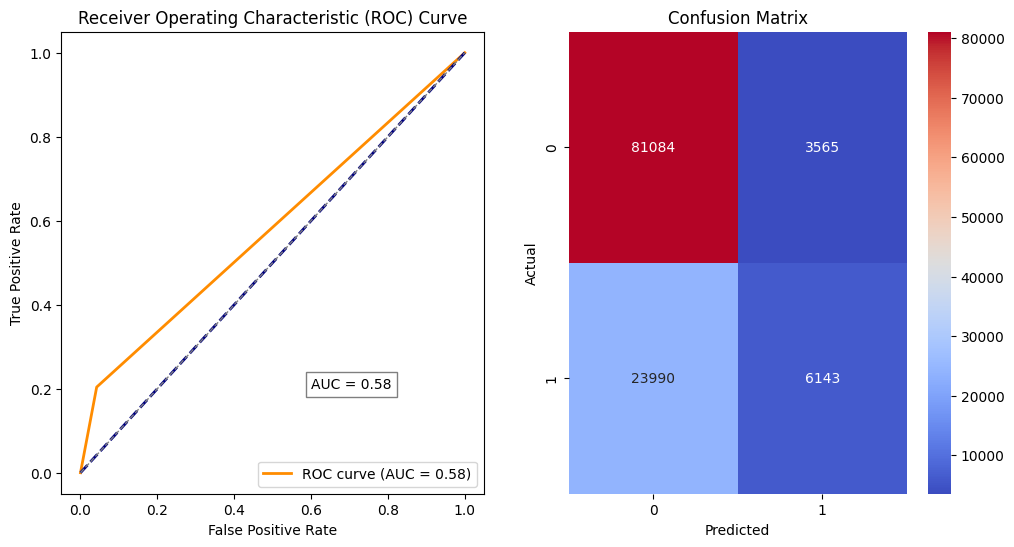

In [18]:
#logistic regression model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_selected, y_train)

# Predict using the trained model on the selected test set
y_pred_log = log_model.predict(X_test_selected)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_log)
print(f"Accuracy: {accuracy:.2f}")

# Compute confusion matrix
conf_matrix_log = confusion_matrix(y_test, y_pred_log)
print("Confusion Matrix:")
print(conf_matrix_log)

# Calculate F1 score
f1score = f1_score(y_test, y_pred_log)
print(f"F1 Score: {f1score:.2f}")

plt.figure(figsize=(12, 6))
# visualise confusion metric as heatmap
plt.subplot(1,2,2)
sns.heatmap(conf_matrix_log, annot=True, cmap='coolwarm', fmt='d', annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


# plot roc and auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_log)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot y=x line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Display AUC value on the plot
plt.text(0.6, 0.2, 'AUC = {:.2f}'.format(roc_auc), bbox=dict(facecolor='white', alpha=0.5))

plt.show()



In [19]:
# #SVM model
# # Initialize and train SVM with selected features
# svm_model = SVC(kernel='linear')
# svm_model.fit(X_train_selected, y_train)

# # Predict using the trained SVM model on the selected test set
# y_pred_svm = svm_model.predict(X_test_selected)

# # Calculate accuracy
# accuracy_svm = accuracy_score(y_test, y_pred_svm)
# print(f"SVM Accuracy: {accuracy_svm:.2f}")

# # Compute confusion matrix
# conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
# print("SVM Confusion Matrix:")
# print(conf_matrix_svm)

# # Calculate F1 score
# f1score_svm = f1_score(y_test, y_pred_svm)
# print(f"SVM F1 Score: {f1score_svm:.2f}")

# plt.figure(figsize=(12, 6))
# # visualise confusion metric as heatmap
# plt.subplot(1,2,2)
# sns.heatmap(conf_matrix_svm, annot=True, cmap='coolwarm', fmt='d', annot_kws={"size": 10})
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')


# # plot roc and auc

# # Calculate the ROC curve
# fpr, tpr, _ = roc_curve(y_test, y_pred_svm)

# # Calculate the AUC score
# roc_auc = auc(fpr, tpr)

# # Plot ROC curve
# plt.subplot(1, 2, 1)
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")

# # Plot y=x line
# plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# # Display AUC value on the plot
# plt.text(0.6, 0.2, 'AUC = {:.2f}'.format(roc_auc), bbox=dict(facecolor='white', alpha=0.5))

# plt.show()

Random Forest Accuracy: 0.76
Random Forest Confusion Matrix:
[[80976  3673]
 [23977  6156]]
Random Forest F1 Score: 0.31


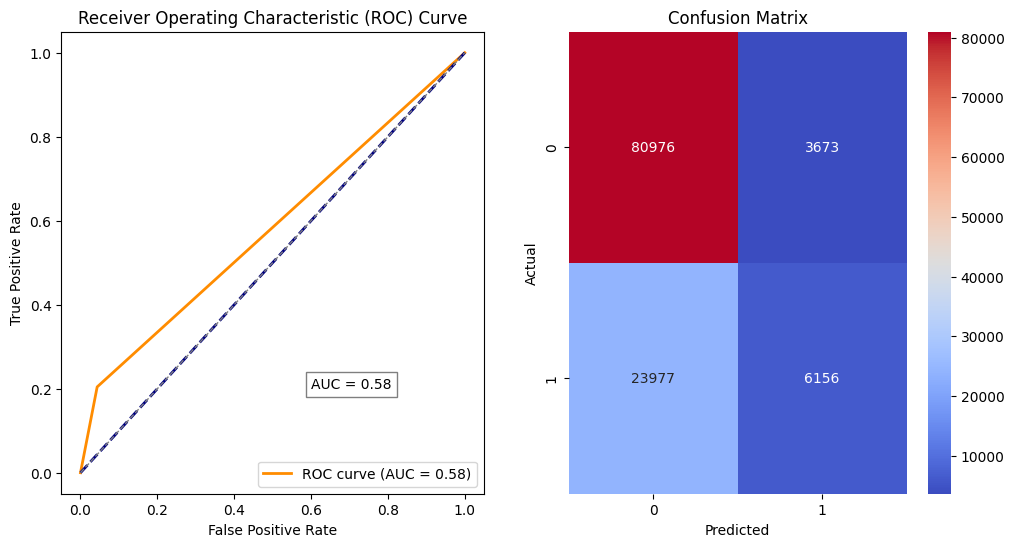

In [21]:
#randomforest model
# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust n_estimators and other hyperparameters

# Train the Random Forest model
rf_model.fit(X_train_selected, y_train)

# Predict using the trained Random Forest model on the test set
X_test_selected = k_best_selector.transform(X_test)  # Transform the test set using the same feature selection
y_pred_rf = rf_model.predict(X_test_selected)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

# Compute confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Random Forest Confusion Matrix:")
print(conf_matrix_rf)

# Calculate F1 score
f1score_rf = f1_score(y_test, y_pred_rf)
print(f"Random Forest F1 Score: {f1score_rf:.2f}")

plt.figure(figsize=(12, 6))

# visualise confusion metric as heatmap
plt.subplot(1,2,2)
sns.heatmap(conf_matrix_rf, annot=True, cmap='coolwarm', fmt='d', annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


# plot roc and auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_rf)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot y=x line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Display AUC value on the plot
plt.text(0.6, 0.2, 'AUC = {:.2f}'.format(roc_auc), bbox=dict(facecolor='white', alpha=0.5))

plt.show()



Accuracy:
Accuracy is the proportion of correctly classified instances. While Random Forest, logistic regression and SVM have similar accuracies (around 75-76%), it's important to consider other metrics for a more complete picture.

F1 Score:
F1 score is the harmonic mean of precision and recall. It's a good metric when there's an imbalance in the class distribution. In your case, Random Forest has a slightly higher F1 score (0.31) compared to SVM (0.21) and logistic regression (0.30)

Conclusion:
Logistic Regression and Random Forest perform similarly, with a slight advantage in F1 score for Random Forest.
SVM, while having a comparable accuracy, lags behind in terms of F1 score, indicating a trade-off between precision and recall.
Consider the specific goals of your application. If a balanced trade-off between precision and recall is crucial, Random Forest may be a reasonable choice. If interpretability is a priority, Logistic Regression might be preferred.
Further model tuning, feature engineering, or exploring advanced techniques (such as deep learning) could potentially improve the performance of your models.


We will be focusing on lstm as it is effective at capturing complex relationships in sequential data.
It requires alot of data which in this case we have.

In [22]:
#lstm (1/2)
X = imdb_reviews_bigrams['bigram_text']
y = imdb_reviews_bigrams['is_spoiler']

#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#vectorize
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features based on your data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Feature selection using SelectKBest on training set
k_best_selector = SelectKBest(score_func=chi2, k=100)  # You can adjust k based on your data
X_train_selected = k_best_selector.fit_transform(X_train_tfidf, y_train)
X_test_selected = k_best_selector.transform(X_test_tfidf)

# Scale the data
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Convert labels to binary format
y_train_binary = y_train.astype('int')
y_test_binary = y_test.astype('int')

# Tokenize and pad sequences
max_words = 10000  # You can adjust based on your vocabulary size
max_len = 50 # You can adjust based on the desired sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post', truncating='post')

Epoch 1/10
6457/6457 [==============================] - 184s 28ms/step - loss: 0.5557 - accuracy: 0.7437 - val_loss: 0.5604 - val_accuracy: 0.7353
Epoch 2/10
6457/6457 [==============================] - 191s 30ms/step - loss: 0.5382 - accuracy: 0.7482 - val_loss: 0.5463 - val_accuracy: 0.7469
Epoch 3/10
6457/6457 [==============================] - 185s 29ms/step - loss: 0.5260 - accuracy: 0.7528 - val_loss: 0.5502 - val_accuracy: 0.7467
Epoch 4/10
6457/6457 [==============================] - 185s 29ms/step - loss: 0.5132 - accuracy: 0.7586 - val_loss: 0.5588 - val_accuracy: 0.7384
Epoch 5/10
3587/3587 [==============================] - 19s 5ms/step
Test Accuracy: 0.7485
Confusion Matrix:
[[83945   704]
 [28166  1967]]
F1 Score: 0.1199


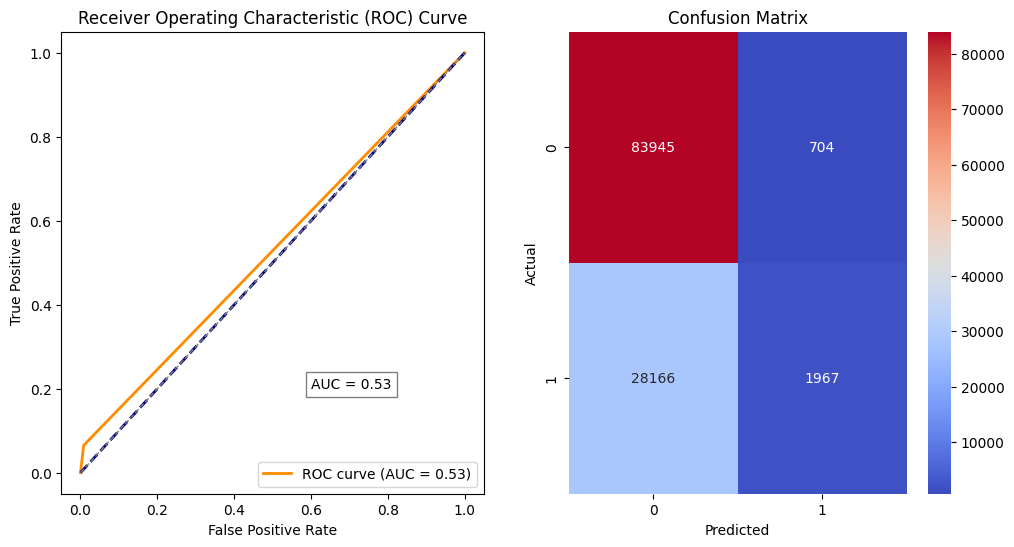

In [23]:
#lstm model(2/2)
# Build the LSTM model
embedding_dim = 50  # You can adjust based on your choice
lstm_units = 100  # You can adjust based on your choice

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(units=lstm_units))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train_padded, y_train_binary, epochs=10, batch_size=64, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model on the test set
y_pred_lstm = (model.predict(X_test_padded) > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test_binary, y_pred_lstm)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_lstm)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate F1 score
f1score = f1_score(y_test_binary, y_pred_lstm)
print(f"F1 Score: {f1score:.4f}")

plt.figure(figsize=(12, 6))
# visualise confusion metric as heatmap
plt.subplot(1,2,2)
sns.heatmap(conf_matrix, annot=True, cmap='coolwarm', fmt='d', annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


# plot roc and auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_lstm)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot y=x line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Display AUC value on the plot
plt.text(0.6, 0.2, 'AUC = {:.2f}'.format(roc_auc), bbox=dict(facecolor='white', alpha=0.5))

plt.show()

The reason for a high accuracy but a low F1 score in the context of the LSTM model could be attributed to class imbalance. F1 score takes into account both precision and recall, and it's particularly sensitive to false positives and false negatives.

In [24]:
#check for class imbalance
count_classes = imdb_reviews_bigrams['is_spoiler'].value_counts()
print(count_classes)

is_spoiler
0    422986
1    150923
Name: count, dtype: int64


In [25]:
#lstm addressing imbalance class(1/2)
X = imdb_reviews_bigrams['bigram_text']
y = imdb_reviews_bigrams['is_spoiler']

#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

#vectorize
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features based on your data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Feature selection using SelectKBest on training set
k_best_selector = SelectKBest(score_func=chi2, k=100)  # You can adjust k based on your data
X_train_selected = k_best_selector.fit_transform(X_train_tfidf, y_train)
X_test_selected = k_best_selector.transform(X_test_tfidf)

# Scale the data
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Convert labels to binary format
y_train_binary = y_train.astype('int')
y_test_binary = y_test.astype('int')

# Tokenize and pad sequences
max_words = 10000  # You can adjust based on your vocabulary size
max_len = 50 # You can adjust based on the desired sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post', truncating='post')

Epoch 1/10
6457/6457 [==============================] - 189s 29ms/step - loss: 0.6625 - accuracy: 0.5860 - val_loss: 0.6548 - val_accuracy: 0.5944
Epoch 2/10
6457/6457 [==============================] - 183s 28ms/step - loss: 0.6422 - accuracy: 0.6125 - val_loss: 0.6529 - val_accuracy: 0.6041
Epoch 3/10
6457/6457 [==============================] - 179s 28ms/step - loss: 0.6222 - accuracy: 0.6355 - val_loss: 0.6561 - val_accuracy: 0.5891
Epoch 4/10
6457/6457 [==============================] - 179s 28ms/step - loss: 0.5987 - accuracy: 0.6557 - val_loss: 0.6797 - val_accuracy: 0.5745
Epoch 5/10
3587/3587 [==============================] - 19s 5ms/step
Test Accuracy: 0.6054
Confusion Matrix:
[[51875 32774]
 [12524 17609]]
F1 Score: 0.4374


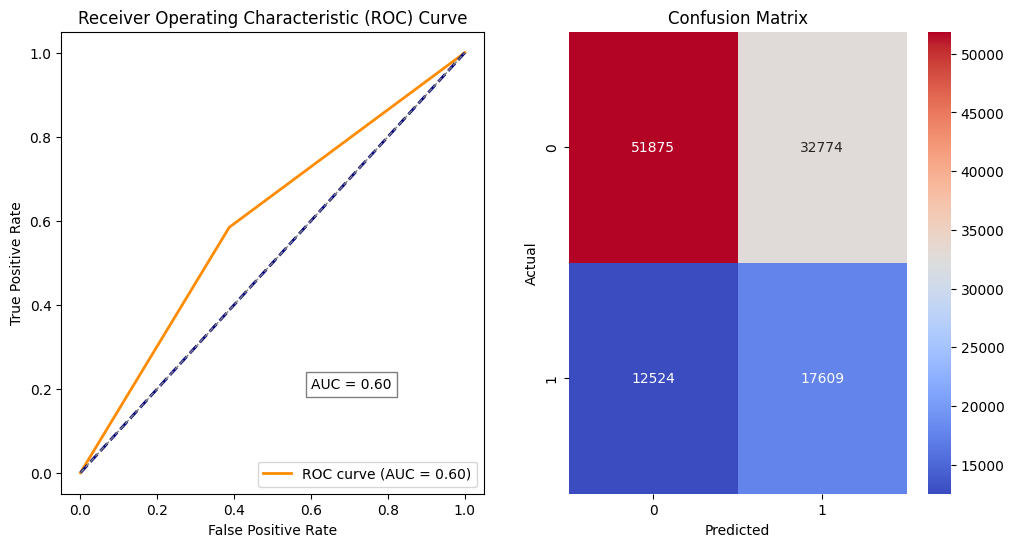

In [26]:
#lstm addressing imbalance class(2/2)
# Build the LSTM model
embedding_dim = 50  # You can adjust based on your choice
lstm_units = 100  # You can adjust based on your choice

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(units=lstm_units))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with class weights
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_padded, y_train_binary, epochs=10, batch_size=64, validation_split=0.1, callbacks=[early_stopping], class_weight=class_weights_dict)

# Evaluate the model on the test set
y_pred_lstm2 = (model.predict(X_test_padded) > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test_binary, y_pred_lstm2)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_lstm2)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate F1 score
f1score = f1_score(y_test_binary, y_pred_lstm2)
print(f"F1 Score: {f1score:.4f}")

plt.figure(figsize=(12, 6))
# visualise confusion metric as heatmap
plt.subplot(1,2,2)
sns.heatmap(conf_matrix, annot=True, cmap='coolwarm', fmt='d', annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


# plot roc and auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_lstm2)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot y=x line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Display AUC value on the plot
plt.text(0.6, 0.2, 'AUC = {:.2f}'.format(roc_auc), bbox=dict(facecolor='white', alpha=0.5))

plt.show()

Given the context of detecting movie spoilers, where the classes are imbalanced, optimizing for F1 score might be more relevant. F1 score considers both precision and recall, providing a better balance, especially when false positives and false negatives carry different costs. Drop in accuracy is accompanied by an improvement in F1 score and better performance on the minority class (spoilers in this case), it could be considered a worthwhile trade-off. 

Epoch 1/10
6457/6457 [==============================] - 203s 31ms/step - loss: 0.6594 - accuracy: 0.5982 - val_loss: 0.6664 - val_accuracy: 0.5692
Epoch 2/10
6457/6457 [==============================] - 202s 31ms/step - loss: 0.6384 - accuracy: 0.6257 - val_loss: 0.6464 - val_accuracy: 0.6043
Epoch 3/10
6457/6457 [==============================] - 202s 31ms/step - loss: 0.6172 - accuracy: 0.6479 - val_loss: 0.6553 - val_accuracy: 0.6126
Epoch 4/10
6457/6457 [==============================] - 203s 31ms/step - loss: 0.5933 - accuracy: 0.6704 - val_loss: 0.7075 - val_accuracy: 0.5513
Epoch 5/10
3587/3587 [==============================] - 20s 6ms/step
Test Accuracy: 0.6042
Confusion Matrix:
[[51753 32896]
 [12534 17599]]
F1 Score: 0.4365


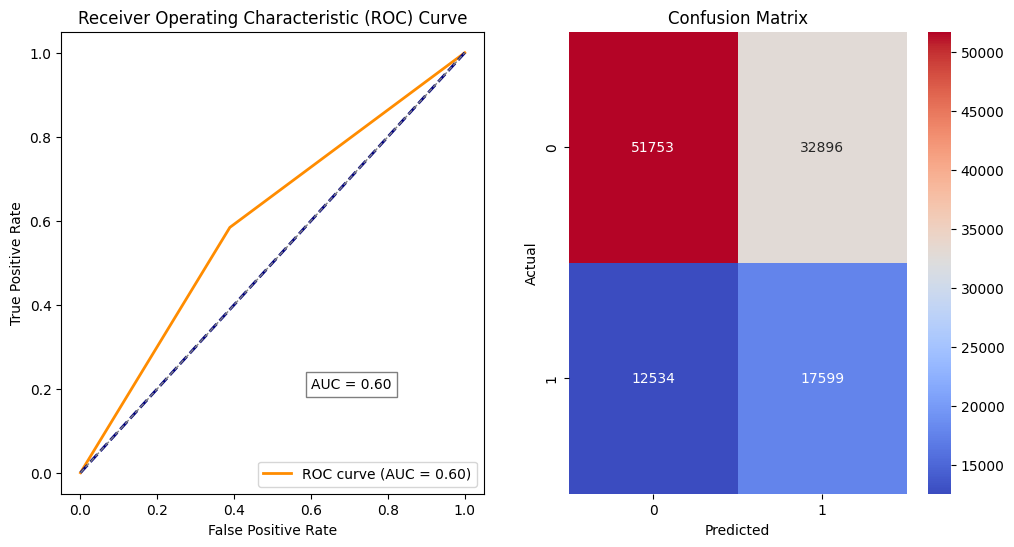

In [27]:
#Improving accuracy for lstm after addressing class imbalance
# Build the Bidirectional LSTM model
embedding_dim = 50
lstm_units = 100

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(units=lstm_units)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with class weights
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_padded, y_train_binary, epochs=10, batch_size=64, validation_split=0.1, callbacks=[early_stopping], class_weight=class_weights_dict)

# Evaluate the model on the test set
y_pred_lstm3 = (model.predict(X_test_padded) > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test_binary, y_pred_lstm3)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_lstm3)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate F1 score
f1score = f1_score(y_test_binary, y_pred_lstm3)
print(f"F1 Score: {f1score:.4f}")

plt.figure(figsize=(12, 6))
# visualise confusion metric as heatmap
plt.subplot(1,2,2)
sns.heatmap(conf_matrix, annot=True, cmap='coolwarm', fmt='d', annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


# plot roc and auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_lstm3)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot y=x line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Display AUC value on the plot
plt.text(0.6, 0.2, 'AUC = {:.2f}'.format(roc_auc), bbox=dict(facecolor='white', alpha=0.5))

plt.show()

 Bidirectional LSTMs come with additional hyperparameters, such as the number of units in each direction, dropout rates, etc. If these hyperparameters are not tuned properly, they might negatively impact the performance of the bidirectional model.

Epoch 1/15
3049/3049 [==============================] - 213s 69ms/step - loss: 0.6585 - accuracy: 0.6001 - val_loss: 0.6612 - val_accuracy: 0.5933
Epoch 2/15
3049/3049 [==============================] - 224s 73ms/step - loss: 0.6383 - accuracy: 0.6265 - val_loss: 0.6379 - val_accuracy: 0.6277
Epoch 3/15
3049/3049 [==============================] - 235s 77ms/step - loss: 0.6201 - accuracy: 0.6450 - val_loss: 0.6623 - val_accuracy: 0.5933
Epoch 4/15
3049/3049 [==============================] - 237s 78ms/step - loss: 0.5994 - accuracy: 0.6630 - val_loss: 0.6566 - val_accuracy: 0.5959
Epoch 5/15
3587/3587 [==============================] - 29s 8ms/step
Test Accuracy: 0.6270
Confusion Matrix:
[[55699 28950]
 [13864 16269]]
F1 Score: 0.4318


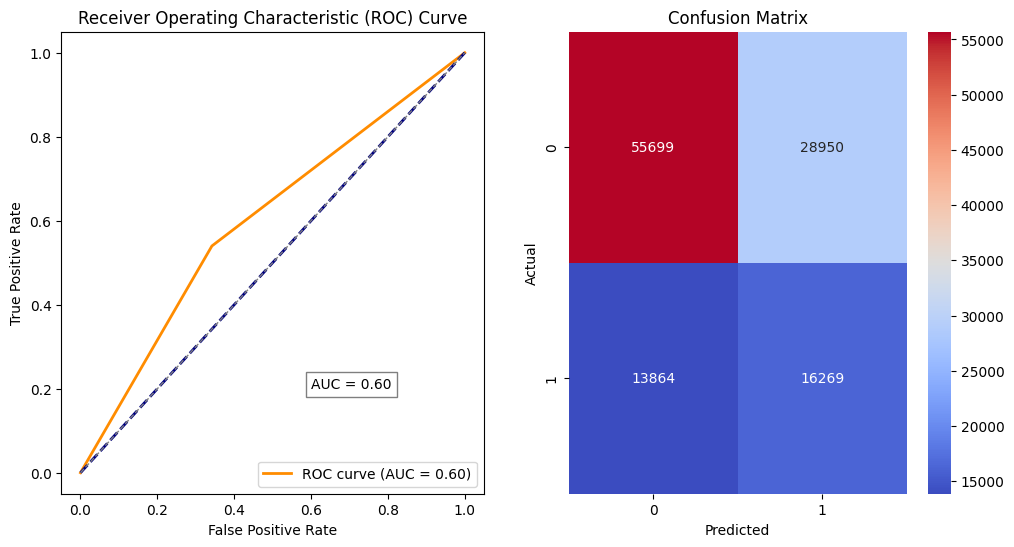

In [28]:
#fine tuning the hyperparameters of the models above
#Improving accuracy for lstm after addressing class imbalance
# Build the Bidirectional LSTM model
embedding_dim = 64 #50 -> 64
lstm_units = 128 #100 -> 128 

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(units=lstm_units)))
model.add(Dropout(0.4)) #0.5 -> 0.4
model.add(Dense(1, activation='sigmoid'))

# Compile the model with class weights
optimizer = Adam(learning_rate=0.0005) #decrease learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_padded, y_train_binary, epochs=15, batch_size=128, validation_split=0.15, callbacks=[early_stopping], class_weight=class_weights_dict) #epochs from 10, batch size from 64 and validation from 0.1

# Evaluate the model on the test set
y_pred_lstm4 = (model.predict(X_test_padded) > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test_binary, y_pred_lstm4)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_lstm4)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate F1 score
f1score = f1_score(y_test_binary, y_pred_lstm4)
print(f"F1 Score: {f1score:.4f}")

plt.figure(figsize=(12, 6))
# visualise confusion metric as heatmap
plt.subplot(1,2,2)
sns.heatmap(conf_matrix, annot=True, cmap='coolwarm', fmt='d', annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


# plot roc and auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_lstm4)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot y=x line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Display AUC value on the plot
plt.text(0.6, 0.2, 'AUC = {:.2f}'.format(roc_auc), bbox=dict(facecolor='white', alpha=0.5))

plt.show()

Epoch 1/20
6098/6098 [==============================] - 609s 100ms/step - loss: 0.6586 - accuracy: 0.5984 - val_loss: 0.6575 - val_accuracy: 0.5935
Epoch 2/20
6098/6098 [==============================] - 627s 103ms/step - loss: 0.6348 - accuracy: 0.6316 - val_loss: 0.6816 - val_accuracy: 0.5741
Epoch 3/20
6098/6098 [==============================] - 658s 108ms/step - loss: 0.6087 - accuracy: 0.6579 - val_loss: 0.6782 - val_accuracy: 0.5804
Epoch 4/20
3587/3587 [==============================] - 95s 26ms/step
Test Accuracy: 0.5926
Confusion Matrix:
[[49449 35200]
 [11557 18576]]
F1 Score: 0.4428


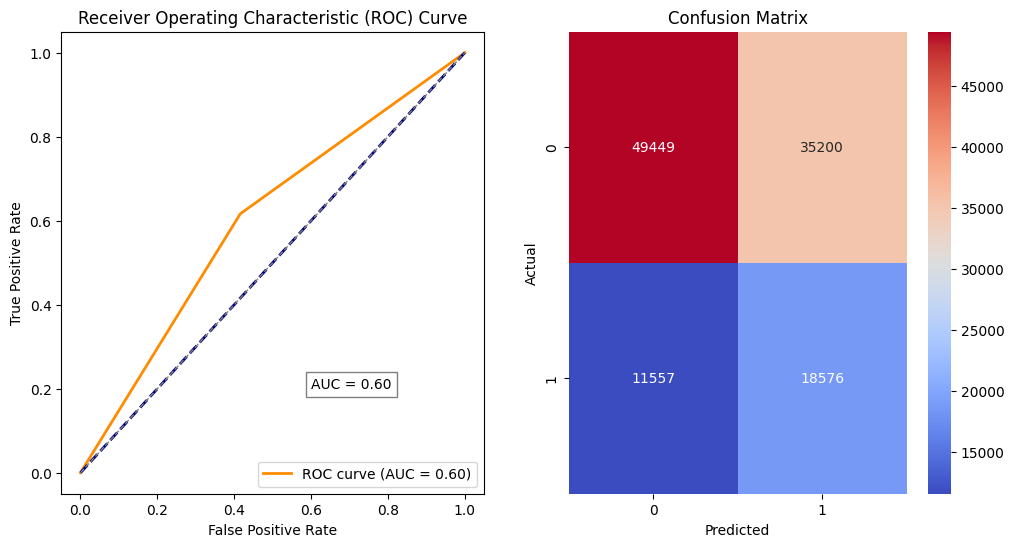

In [29]:
#fine tuning the hyperparameters of the models
#Improving accuracy for lstm after addressing class imbalance
# Build the Bidirectional LSTM model
embedding_dim = 128 #64 -> 128
lstm_units = 256 #128 -> 256

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(units=lstm_units)))
model.add(Dropout(0.4)) #0.5 -> 0.4
model.add(Dense(1, activation='sigmoid'))

# Compile the model with class weights
optimizer = Adam(learning_rate=0.0005) #decrease learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_padded, y_train_binary, epochs=20, batch_size=64, validation_split=0.15, callbacks=[early_stopping], class_weight=class_weights_dict) #epochs from 10, batch size from 64 and validation from 0.1

# Evaluate the model on the test set
y_pred_lstm5 = (model.predict(X_test_padded) > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test_binary, y_pred_lstm5)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_lstm5)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate F1 score
f1score = f1_score(y_test_binary, y_pred_lstm5)
print(f"F1 Score: {f1score:.4f}")

plt.figure(figsize=(12, 6))
# visualise confusion metric as heatmap
plt.subplot(1,2,2)
sns.heatmap(conf_matrix, annot=True, cmap='coolwarm', fmt='d', annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


# plot roc and auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_lstm5)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot y=x line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Display AUC value on the plot
plt.text(0.6, 0.2, 'AUC = {:.2f}'.format(roc_auc), bbox=dict(facecolor='white', alpha=0.5))

plt.show()

Epoch 1/20
6098/6098 [==============================] - 690s 113ms/step - loss: 0.6586 - accuracy: 0.6016 - val_loss: 0.6436 - val_accuracy: 0.6193
Epoch 2/20
6098/6098 [==============================] - 707s 116ms/step - loss: 0.6336 - accuracy: 0.6328 - val_loss: 0.6330 - val_accuracy: 0.6334
Epoch 3/20
6098/6098 [==============================] - 704s 116ms/step - loss: 0.6044 - accuracy: 0.6611 - val_loss: 0.6448 - val_accuracy: 0.6231
Epoch 4/20
6098/6098 [==============================] - 696s 114ms/step - loss: 0.5691 - accuracy: 0.6906 - val_loss: 0.6630 - val_accuracy: 0.6166
Epoch 5/20
3587/3587 [==============================] - 107s 30ms/step
Test Accuracy: 0.6350
Confusion Matrix:
[[57472 27177]
 [14719 15414]]
F1 Score: 0.4239


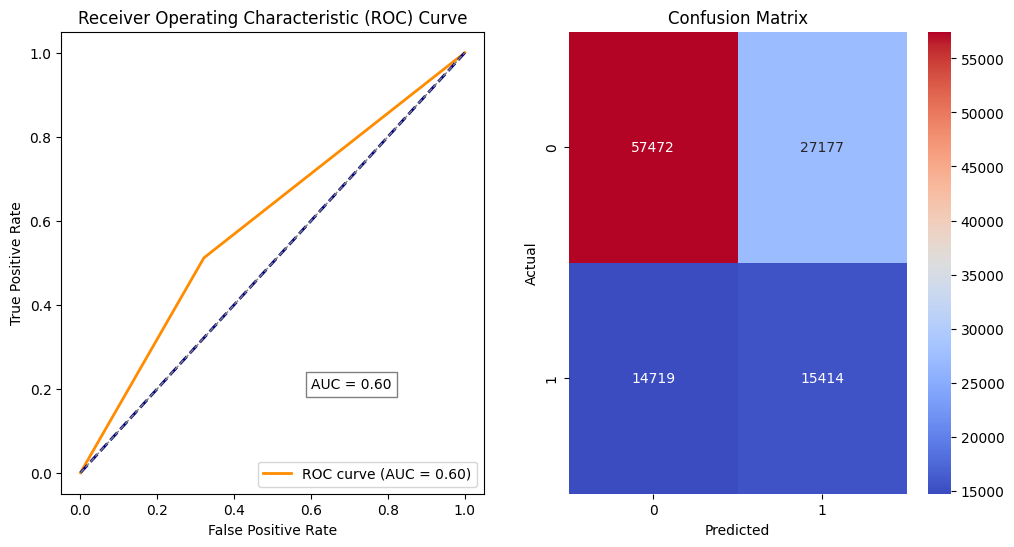

In [30]:
#fine tuning the hyperparameters of the models
#Improving accuracy for lstm after addressing class imbalance
# Build the Bidirectional LSTM model
embedding_dim = 256 #64 -> 128
lstm_units = 256 #128 -> 256

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(units=lstm_units)))
model.add(Dropout(0.4)) #0.5 -> 0.4
model.add(Dense(1, activation='sigmoid'))

# Compile the model with class weights
optimizer = Adam(learning_rate=0.0005) #decrease learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_padded, y_train_binary, epochs=20, batch_size=64, validation_split=0.15, callbacks=[early_stopping], class_weight=class_weights_dict) #epochs from 10, batch size from 64 and validation from 0.1

# Evaluate the model on the test set
y_pred_lstm6 = (model.predict(X_test_padded) > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test_binary, y_pred_lstm6)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_lstm6)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate F1 score
f1score = f1_score(y_test_binary, y_pred_lstm6)
print(f"F1 Score: {f1score:.4f}")

plt.figure(figsize=(12, 6))
# visualise confusion metric as heatmap
plt.subplot(1,2,2)
sns.heatmap(conf_matrix, annot=True, cmap='coolwarm', fmt='d', annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


# plot roc and auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_lstm6)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot y=x line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Display AUC value on the plot
plt.text(0.6, 0.2, 'AUC = {:.2f}'.format(roc_auc), bbox=dict(facecolor='white', alpha=0.5))

plt.show()

Epoch 1/20
6098/6098 [==============================] - 1582s 259ms/step - loss: 0.6607 - accuracy: 0.5975 - val_loss: 0.6648 - val_accuracy: 0.5755
Epoch 2/20
6098/6098 [==============================] - 1616s 265ms/step - loss: 0.6388 - accuracy: 0.6255 - val_loss: 0.6403 - val_accuracy: 0.6096
Epoch 3/20
6098/6098 [==============================] - 1590s 261ms/step - loss: 0.6137 - accuracy: 0.6514 - val_loss: 0.6473 - val_accuracy: 0.6118
Epoch 4/20
6098/6098 [==============================] - 1601s 263ms/step - loss: 0.5792 - accuracy: 0.6818 - val_loss: 0.6938 - val_accuracy: 0.5910
Epoch 5/20
3587/3587 [==============================] - 205s 57ms/step
Test Accuracy: 0.6074
Confusion Matrix:
[[52368 32281]
 [12782 17351]]
F1 Score: 0.4351


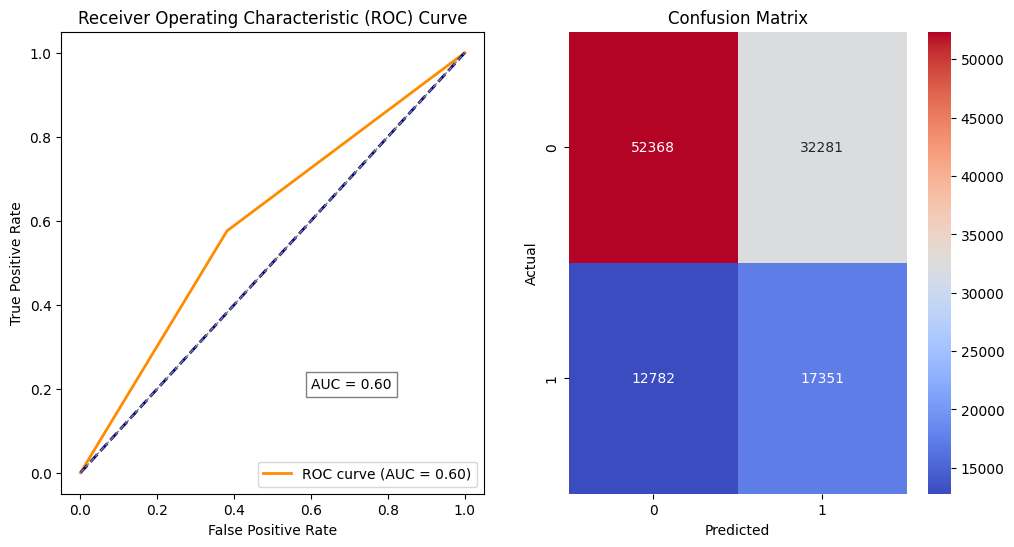

In [31]:
#fine tuning the hyperparameters of the models by adding additional lstm layer
#Improving accuracy for lstm after addressing class imbalance
# Build the Bidirectional LSTM model
embedding_dim = 256 #64 -> 128
lstm_units = 256 #128 -> 256

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(units=lstm_units,return_sequences=True)))
model.add(Bidirectional(LSTM(units=lstm_units))) #additional layer
model.add(Dropout(0.4)) #0.5 -> 0.4
model.add(Dense(1, activation='sigmoid'))

# Compile the model with class weights
optimizer = Adam(learning_rate=0.0005) #decrease learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_padded, y_train_binary, epochs=20, batch_size=64, validation_split=0.15, callbacks=[early_stopping], class_weight=class_weights_dict) #epochs from 10, batch size from 64 and validation from 0.1

# Evaluate the model on the test set
y_pred_lstm7 = (model.predict(X_test_padded) > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test_binary, y_pred_lstm7)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_lstm7)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate F1 score
f1score = f1_score(y_test_binary, y_pred_lstm7)
print(f"F1 Score: {f1score:.4f}")

plt.figure(figsize=(12, 6))
# visualise confusion metric as heatmap
plt.subplot(1,2,2)
sns.heatmap(conf_matrix, annot=True, cmap='coolwarm', fmt='d', annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


# plot roc and auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_lstm7)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot y=x line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Display AUC value on the plot
plt.text(0.6, 0.2, 'AUC = {:.2f}'.format(roc_auc), bbox=dict(facecolor='white', alpha=0.5))

plt.show()

Additional layers can lead to overfitting, especially if the model is too complex for the given dataset. Overfitting occurs when the model learns the training data too well, including its noise and outliers, and fails to generalize to new, unseen data.

Epoch 1/20
6098/6098 [==============================] - 703s 115ms/step - loss: 0.7611 - accuracy: 0.5800 - val_loss: 0.6550 - val_accuracy: 0.6133
Epoch 2/20
6098/6098 [==============================] - 661s 108ms/step - loss: 0.6570 - accuracy: 0.6147 - val_loss: 0.6763 - val_accuracy: 0.5755
Epoch 3/20
6098/6098 [==============================] - 647s 106ms/step - loss: 0.6502 - accuracy: 0.6266 - val_loss: 0.6782 - val_accuracy: 0.5861
Epoch 4/20
3587/3587 [==============================] - 92s 26ms/step
Test Accuracy: 0.6143
Confusion Matrix:
[[53576 31073]
 [13198 16935]]
F1 Score: 0.4334


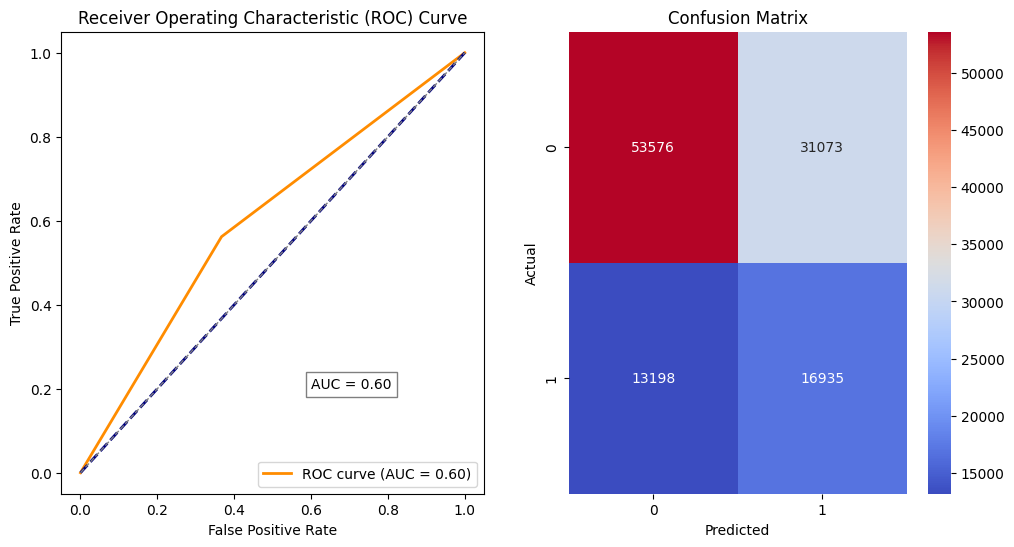

In [32]:
#fine tuning the hyperparameters of the models with regularisation
#Improving accuracy for lstm after addressing class imbalance
# Build the Bidirectional LSTM model
embedding_dim = 256 #64 -> 128
lstm_units = 256 #128 -> 256

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(units=lstm_units, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))) #additional layer + regularisation
model.add(Dropout(0.6)) #0.5 -> 0.6
model.add(Dense(1, activation='sigmoid'))

# Compile the model with class weights
optimizer = Adam(learning_rate=0.0005) #decrease learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_padded, y_train_binary, epochs=20, batch_size=64, validation_split=0.15, callbacks=[early_stopping], class_weight=class_weights_dict) #epochs from 10, batch size from 64 and validation from 0.1

# Evaluate the model on the test set
y_pred_lstm8 = (model.predict(X_test_padded) > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test_binary, y_pred_lstm8)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_lstm8)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate F1 score
f1score = f1_score(y_test_binary, y_pred_lstm8)
print(f"F1 Score: {f1score:.4f}")

plt.figure(figsize=(12, 6))
# visualise confusion metric as heatmap
plt.subplot(1,2,2)
sns.heatmap(conf_matrix, annot=True, cmap='coolwarm', fmt='d', annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


# plot roc and auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_lstm8)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot y=x line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Display AUC value on the plot
plt.text(0.6, 0.2, 'AUC = {:.2f}'.format(roc_auc), bbox=dict(facecolor='white', alpha=0.5))

plt.show()

The strength of the regularization may be too high, causing the model to penalize the weights too much

Epoch 1/20
6098/6098 [==============================] - 704s 115ms/step - loss: 0.6770 - accuracy: 0.5890 - val_loss: 0.6620 - val_accuracy: 0.5997
Epoch 2/20
6098/6098 [==============================] - 700s 115ms/step - loss: 0.6511 - accuracy: 0.6202 - val_loss: 0.6602 - val_accuracy: 0.6100
Epoch 3/20
6098/6098 [==============================] - 680s 111ms/step - loss: 0.6436 - accuracy: 0.6334 - val_loss: 0.6763 - val_accuracy: 0.5747
Epoch 4/20
6098/6098 [==============================] - 656s 108ms/step - loss: 0.6365 - accuracy: 0.6438 - val_loss: 0.6445 - val_accuracy: 0.6299
Epoch 5/20
6098/6098 [==============================] - 655s 107ms/step - loss: 0.6300 - accuracy: 0.6521 - val_loss: 0.6650 - val_accuracy: 0.6085
Epoch 6/20
6098/6098 [==============================] - 686s 113ms/step - loss: 0.6249 - accuracy: 0.6568 - val_loss: 0.6658 - val_accuracy: 0.6021
Epoch 7/20
3587/3587 [==============================] - 97s 27ms/step
Test Accuracy: 0.6309
Confusion Matrix:
[[

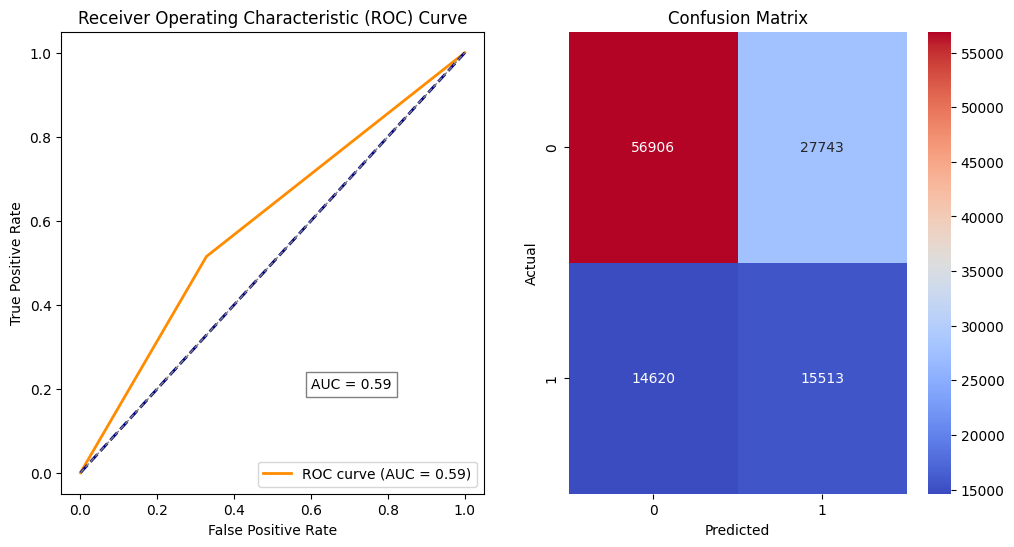

In [33]:
#fine tuning the hyperparameters of the models with regularisation
#Improving accuracy for lstm after addressing class imbalance
# Build the Bidirectional LSTM model
embedding_dim = 256 #64 -> 128
lstm_units = 256 #128 -> 256

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(units=lstm_units, kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)))) #additional layer + regularisation adjusted
model.add(Dropout(0.6)) #0.5 -> 0.6
model.add(Dense(1, activation='sigmoid'))

# Compile the model with class weights
optimizer = Adam(learning_rate=0.0005) #decrease learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_padded, y_train_binary, epochs=20, batch_size=64, validation_split=0.15, callbacks=[early_stopping], class_weight=class_weights_dict) #epochs from 10, batch size from 64 and validation from 0.1

# Evaluate the model on the test set
y_pred_lstm9 = (model.predict(X_test_padded) > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test_binary, y_pred_lstm9)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_lstm9)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate F1 score
f1score = f1_score(y_test_binary, y_pred_lstm9)
print(f"F1 Score: {f1score:.4f}")

plt.figure(figsize=(12, 6))
# visualise confusion metric as heatmap
plt.subplot(1,2,2)
sns.heatmap(conf_matrix, annot=True, cmap='coolwarm', fmt='d', annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


# plot roc and auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_lstm9)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot y=x line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Display AUC value on the plot
plt.text(0.6, 0.2, 'AUC = {:.2f}'.format(roc_auc), bbox=dict(facecolor='white', alpha=0.5))

plt.show()

In [34]:
#bert (1/2)
X = imdb_reviews_bigrams['bigram_text']
y = imdb_reviews_bigrams['is_spoiler']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenize and pad sequences
max_len = 50  # You can adjust the maximum sequence length
X_train_tokenized = tokenizer(list(X_train), padding=True, truncation=True, return_tensors='pt', max_length=max_len)
X_test_tokenized = tokenizer(list(X_test), padding=True, truncation=True, return_tensors='pt', max_length=max_len)

# Convert labels to torch tensors
y_train_tensor = torch.tensor(y_train.values)
y_test_tensor = torch.tensor(y_test.values)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- attempting n-folds and cross validation after oversampling minority class -

In [ ]:
#fine tuning the hyperparameters of the models by adding additional lstm layer
#Improving accuracy for lstm after addressing class imbalance
# Build the Bidirectional LSTM model
embedding_dim = 256 #64 -> 128
lstm_units = 256 #128 -> 256

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(units=lstm_units,return_sequences=True)))
model.add(Bidirectional(LSTM(units=lstm_units))) #additional layer
model.add(Dropout(0.4)) #0.5 -> 0.4
model.add(Dense(1, activation='sigmoid'))

# Compile the model with class weights
optimizer = Adam(learning_rate=0.0005) #decrease learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_padded, y_train_binary, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping], class_weight=class_weights_dict) #epochs from 10, batch size from 64 and validation from 0.1

# Evaluate the model on the test set
y_pred_lstm7 = (model.predict(X_test_padded) > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test_binary, y_pred_lstm7)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_lstm7)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate F1 score
f1score = f1_score(y_test_binary, y_pred_lstm7)
print(f"F1 Score: {f1score:.4f}")

plt.figure(figsize=(12, 6))
# visualise confusion metric as heatmap
plt.subplot(1,2,2)
sns.heatmap(conf_matrix, annot=True, cmap='coolwarm', fmt='d', annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


# plot roc and auc

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_lstm7)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot y=x line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Display AUC value on the plot
plt.text(0.6, 0.2, 'AUC = {:.2f}'.format(roc_auc), bbox=dict(facecolor='white', alpha=0.5))

plt.show()

In [ ]:
#lstm addressing imbalance class(1/2)
X = imdb_reviews_bigrams['bigram_text']
y = imdb_reviews_bigrams['is_spoiler']

#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#oversample minority class (is_spoiler=1)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

#vectorize
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features based on your data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Feature selection using SelectKBest on training set
k_best_selector = SelectKBest(score_func=chi2, k=100)  # You can adjust k based on your data
X_train_selected = k_best_selector.fit_transform(X_train_tfidf, y_train)
X_test_selected = k_best_selector.transform(X_test_tfidf)

# Scale the data
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Convert labels to binary format
y_train_binary = y_train.astype('int')
y_test_binary = y_test.astype('int')

# Tokenize and pad sequences
max_words = 10000  # You can adjust based on your vocabulary size
max_len = 50 # You can adjust based on the desired sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post', truncating='post')